In [158]:
from typing import Callable

import numpy as np
import scipy.constants as consts
import matplotlib.pyplot as plt
from matplotlib import patheffects

%matplotlib widget

In [159]:
# Define constants
RHO = 1.225  # kg / m^3

# Define requirements
v_cruise = 30. * consts.knot
v_stall = 8. * consts.knot
r_turn = 200 * consts.foot
climb_rate = 400 * consts.foot / consts.minute

# Define assumptions
v_turn = v_cruise
v_climb = 0.8 * v_cruise

# Conservative
CL_max_conserv = 1.2
CD_0_conserv = 0.05
eta_prop_conserv = 0.6
L_D_max_conserv = 10
AR_conserv = 5
e_oswald_conserv = 0.70
k_conserv = 1 / (np.pi * AR_conserv * e_oswald_conserv)

# Aggressive
CL_max_aggr = 1.8
CD_0_aggr = 0.025
eta_prop_aggr = 0.85
L_D_max_aggr = 20
AR_aggr = 8
e_oswald_aggr = 0.85
k_aggr = 1 / (np.pi * AR_aggr * e_oswald_aggr)

# Derived values
climb_angle = np.asin(climb_rate / v_cruise)
load_factor = np.sqrt((v_turn**2 / r_turn / consts.g)**2 + 1)
bank_angle = np.acos(1 / load_factor)

print(f"Climb angle      = {np.rad2deg(climb_angle):.2f}°")
print(f"Turn load factor = {load_factor:.3f}")
print(f"Turn bank angle  = {np.rad2deg(bank_angle):.1f}°")

Climb angle      = 7.57°
Turn load factor = 1.076
Turn bank angle  = 21.7°


In [160]:
def mk_stall_cond_func(
    CL_max: float, vs: float, rho: float = RHO
) -> Callable[[np.ndarray, np.ndarray], np.ndarray]:
    """
    Make stall condition constraint function.

    :param float CL_max: Maximum lift coefficient
    :param float vs: Stall true airspeed
    :param float rho: (optional) Atmospheric density
    :return Callable[[np.ndarray, np.ndarray], np.ndarray] f: Function mapping wing and power loading
    """

    def f(ws: np.ndarray, wp: np.ndarray) -> np.ndarray:
        return (CL_max * rho * vs**2 * 0.5) - ws

    return f

In [161]:
def mk_cruise_cond_func(
    vc: float, CD_0: float, eta_p: float, rho: float = RHO, CD_scale: float = 1.1
) -> Callable[[np.ndarray, np.ndarray], np.ndarray]:
    """
    Make cruise condition constraint function.

    :param float vc: Cruise true airspeed
    :param float CD_0: Zero-lift form drag
    :param float eta_p: Propeller efficiency
    :param float rho: (optional) Atmospheric density
    :param float CD_scale: (optional) Scale factor for total drag (including induced drag)
    :return Callable[[np.ndarray, np.ndarray], np.ndarray] f: Function mapping wing and power loading
    """

    def f(ws: np.ndarray, wp: np.ndarray) -> np.ndarray:
        return (eta_p * 2.) / (rho * vc**3 * CD_scale * CD_0) * ws - wp

    return f

In [162]:
def mk_climb_cond_func(
    vcl: float, gamma: float, eta_p: float, L_D_max: float, L_D_scale: float = 0.866
) -> Callable[[np.ndarray, np.ndarray], np.ndarray]:
    """
    Make cruise condition constraint function.

    :param float vcl: Climb true airspeed
    :param float gamma: Climb rate
    :param float eta_p: Propeller efficiency
    :param float L_D_max: Maximum lift-to-drag ratio L/D
    :param float L_D_scale: (optional) Scale factor for L/D ration during climb
    :return Callable[[np.ndarray, np.ndarray], np.ndarray] f: Function mapping wing and power loading
    """

    def f(ws: np.ndarray, wp: np.ndarray) -> np.ndarray:
        return eta_p / vcl / (gamma + 1 / (L_D_max * L_D_scale)) - wp

    return f

In [163]:
def mk_turn_cond_func(
    vtr: float, CD_0: float, eta_p: float, n: float, k: float, rho: float = RHO,
) -> Callable[[np.ndarray, np.ndarray], np.ndarray]:
    """
    Make cruise condition constraint function.

    :param float vtr: Turn true airspeed
    :param float CD_0: Zero-lift form drag
    :param float eta_p: Propeller efficiency
    :param float n: Turn load factor
    :param float k: Induced drag factor 1 / π AR e
    :param float rho: (optional) Atmospheric density
    :return Callable[[np.ndarray, np.ndarray], np.ndarray] f: Function mapping wing and power loading
    """
    
    q = 0.5 * rho * vtr**2

    def f(ws: np.ndarray, wp: np.ndarray) -> np.ndarray:
        return (eta_p / q / vtr / (k * (n / q)**2 * ws + CD_0 / ws)) - wp

    return f

In [164]:
# Conservative constraints
stall_f_conserv = mk_stall_cond_func(CL_max_conserv, v_stall)
cruise_f_conserv = mk_cruise_cond_func(v_cruise, CD_0_conserv, eta_prop_conserv)
climb_f_conserv = mk_climb_cond_func(v_climb, climb_angle, eta_prop_conserv, L_D_max_conserv)
turn_f_conserv = mk_turn_cond_func(v_turn, CD_0_conserv, eta_prop_conserv, load_factor, k_conserv)

# Agressive constraints
stall_f_aggr = mk_stall_cond_func(CL_max_aggr, v_stall)
cruise_f_aggr = mk_cruise_cond_func(v_cruise, CD_0_aggr, eta_prop_aggr)
climb_f_aggr = mk_climb_cond_func(v_climb, climb_angle, eta_prop_aggr, L_D_max_aggr)
turn_f_aggr = mk_turn_cond_func(v_turn, CD_0_aggr, eta_prop_aggr, load_factor, k_aggr)

In [165]:
# Constraint domain
min_wing_loading = 2.9 * consts.g  # Ozone Buzz Z3 MS (paraglider)
max_wing_loading = 837 * consts.g  # McDonnel Douglas MD-11 (widebody airliner)
min_power_loading = 1 / (634 / consts.g)  # Supermarine S.6B (racing aircraft)
max_power_loading = 1 / (106 / consts.g)  # Boeing B-29 (heavy bomber)

ws_lo = np.floor(np.log10(min_wing_loading)) - 1
ws_hi = np.floor(np.log10(max_wing_loading))
wp_lo = np.floor(np.log10(min_power_loading)) - 1
wp_hi = np.ceil(np.log10(max_power_loading)) + 1

ws = np.logspace(ws_lo, ws_hi)  # Wing loading N/m^2
wp = np.logspace(wp_lo, wp_hi)  # Power loading N/W

ws, wp = np.meshgrid(ws, wp)

In [166]:
stall_conserv = stall_f_conserv(ws, wp)
cruise_conserv = cruise_f_conserv(ws, wp)
climb_conserv = climb_f_conserv(ws, wp)
turn_conserv = turn_f_conserv(ws, wp)

stall_aggr = stall_f_aggr(ws, wp)
cruise_aggr = cruise_f_aggr(ws, wp)
climb_aggr = climb_f_aggr(ws, wp)
turn_aggr = turn_f_aggr(ws, wp)

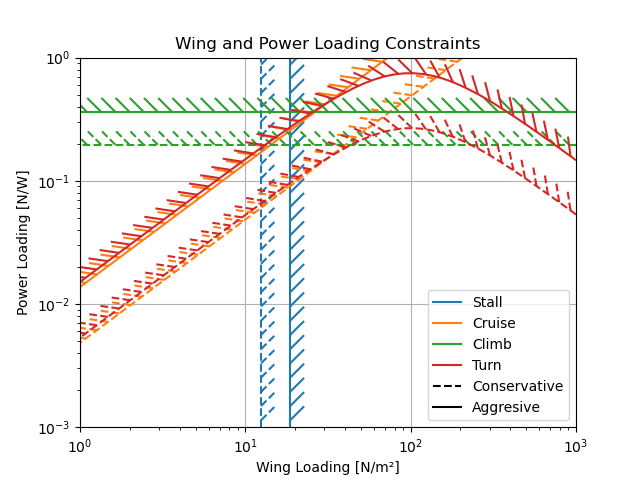

In [169]:
fig, ax = plt.subplots(1,1)
ax.set_xscale('log')
ax.set_yscale('log')

stall_cntr_conserv = ax.contour(ws, wp, stall_conserv, [0], colors="C0", linestyles="--")
stall_cntr_conserv.set(path_effects=[patheffects.withTickedStroke(angle=-45)])
stall_cntr_aggr = ax.contour(ws, wp, stall_aggr, [0], colors="C0", linestyles="-")
stall_cntr_aggr.set(path_effects=[patheffects.withTickedStroke(angle=-45)])

cruise_cntr_conserv = ax.contour(ws, wp, cruise_conserv, [0], colors="C1", linestyles="--")
cruise_cntr_conserv.set(path_effects=[patheffects.withTickedStroke(angle=-45)])
cruise_cntr_aggr = ax.contour(ws, wp, cruise_aggr, [0], colors="C1", linestyles="-")
cruise_cntr_aggr.set(path_effects=[patheffects.withTickedStroke(angle=-45)])

climb_cntr_conserv = ax.contour(ws, wp, climb_conserv, [0], colors="C2", linestyles="--")
climb_cntr_conserv.set(path_effects=[patheffects.withTickedStroke(angle=-45)])
climb_cntr_aggr = ax.contour(ws, wp, climb_aggr, [0], colors="C2", linestyles="-")
climb_cntr_aggr.set(path_effects=[patheffects.withTickedStroke(angle=-45)])

turn_cntr_conserv = ax.contour(ws, wp, turn_conserv, [0], colors="C3", linestyles="--")
turn_cntr_conserv.set(path_effects=[patheffects.withTickedStroke(angle=-45)])
turn_cntr_aggr = ax.contour(ws, wp, turn_aggr, [0], colors="C3", linestyles="-")
turn_cntr_aggr.set(path_effects=[patheffects.withTickedStroke(angle=-45)])

ax.set_xlabel("Wing Loading [N/m²]")
ax.set_ylabel("Power Loading [N/W]")
legend_lines = [
    plt.Line2D([], [], color='C0', label="Stall"),
    plt.Line2D([], [], color='C1', label="Cruise"),
    plt.Line2D([], [], color='C2', label="Climb"),
    plt.Line2D([], [], color='C3', label="Turn"),
    plt.Line2D([], [], color='k', linestyle='--', label="Conservative"),
    plt.Line2D([], [], color='k', label="Aggresive"),
]
ax.legend(handles=legend_lines, loc="lower right")
ax.set_title("Wing and Power Loading Constraints")
ax.grid()

In [168]:
12.47 / consts.g, (1 / (.061 / consts.g))

(1.2715861175834766, 160.76475409836067)